#  Stock Movement Analysis Based on Social Media Sentiment
<p style="text-align: justify;">

**Aim**:  Develop a machine learning model that predicts stock movements by scraping data from social media platform Reddit.The model should extract   insights from user-generated content, such as stock discussions, predictions, or sentiment analysis, and accurately forecast stock price  trends

**Reason for Choosing Reddit**:
Reddit is an ideal platform for stock movement analysis because its structure encourages focused discussions. Unlike other social media platforms, Reddit's subreddit communities are dedicated to specific topics, and users are generally expected to stay on-topic within a given subreddit. This minimizes the amount of irrelevant or spam content compared to platforms like Twitter, where posts can often be filled with unrelated hashtags or mentions aimed at increasing reach. Furthermore, Reddit has strong moderation and restrictions on bots making it a more reliable source of authentic discussions and opinions. These characteristics make Reddit a valuable resource for analyzing sentiment in stock-related discussions and predicting stock price trends.

**The Sections covered in the Notebook**:

*   Installation Required Libraries for analysis: Installing/Importing Required libraries for analysis.
*   Data Collection: Code and details for scraping data from Reddit using PRAW.
*   Data Preprocessing: Steps for cleaning and transforming the data.
*   Feature Extraction: Explanation of the features derived from the data.
*   Model Building and Training: Models used and their rationale.
*   Evaluation and Results: Performance metrics and insights.
*   Conclusions and Future Work: Findings and expansion ideas.

</p>



## Installation Required Libraries for analysis

#### Installing Required Libraries
Before we start scraping data and working with the model, we need to install the necessary Python packages.

PRAW:
PRAW (Python Reddit API Wrapper) is a library that allows us to interact with Reddit's API. We'll use this to scrape data from Reddit, such as posts, comments, and subreddits, related to stock discussions.
To install PRAW, we run:
`!pip install praw`


FREDAPI:
FREDAPI allows us to access economic data from the Federal Reserve Economic Data (FRED) database. This data can be used to analyze economic factors like GDP, CPI, and interest rates, which might be useful as features in predicting stock price movements.
To install FREDAPI,  we run:
`!pip install fredapi`

In [451]:
!pip install praw
!pip install fredapi

#### Required Libraries
  1. pandas (pd): For data manipulation and analysis using DataFrames.
  2. numpy (np): For numerical operations and handling arrays.
  3. matplotlib.pyplot (plt) & seaborn (sns): For data visualization.
  4. warnings: To suppress unnecessary warning messages.
  5. praw: To scrape data from Reddit for sentiment analysis.
  6. yfinance (yf): To fetch historical stock market data.
  7. datetime: For handling date and time.
  8. typing: For type annotations (e.g., List, Optional).
  9. plotly.graph_objects (go): For interactive plotting.
  10. requests: To make HTTP requests for data fetching.
  11. fredapi.Fred: To access economic data from FRED.
  12. transformers: For natural language processing tasks (like sentiment analysis).
  13. IPython.display: For displaying HTML elements within the notebook.
  14. sklearn.metrics: For model evaluation metrics (e.g., MAE, R² score).
  15. sklearn.linear_model: Includes linear models like Ridge, Lasso, and Linear Regression.
  16. sklearn.svm: For Support Vector Regression.
  17. sklearn.ensemble: For ensemble models like Random Forest and Gradient Boosting.
  18. sklearn.tree: For Decision Tree Regressor.
  base64 & io.BytesIO: For handling image encoding and binary data.
  19. sklearn.model_selection.train_test_split: To split data into training and testing sets.
  20. sklearn.preprocessing.StandardScaler: For feature scaling.

In [452]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import praw
import yfinance as yf
from datetime import datetime
from typing import List, Optional
import plotly.graph_objects as go
import requests
from fredapi import Fred
from transformers import pipeline
from IPython.display import HTML, display
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import base64
from io import BytesIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")

#### Setting Up Reddit API (PRAW) Credentials
To use PRAW (Python Reddit API Wrapper), you'll need to create Reddit API credentials:

- Create Reddit App:
  * Go to [Reddit App Preferences](https://www.reddit.com/prefs/apps) and click Create App.
  * After creating the app, note down:
    - Client ID (under the "webapp" section)
    - Client Secret
    - User Agent (e.g., python:my_scraper:v1.0 (by u/your_username))

In [453]:
secret='uwNIHxc-TXaihKcbHPIYIaT1xgG-Rw'
script='1dKQuikC4Skehxvu8UuQZA'
user= 'python:scrapper:1.0 (by u/Plastic_Experience74)'

## Data Collection

##### Scraping Stock-Related Data from Reddit for Sentiment Analysis and Stock Movement Prediction

The `get_reddit_stock_titles` function collects posts from Reddit based on specified keywords, such as the Apple ticker 'AAPL' and the keyword "apple," searching through stock-related subreddits. It is designed to focus on popular stock-investing communities, such as 'wallstreetbets,' 'stocks,' and 'investing,' to ensure relevant content. The function filters posts by date and stores the results in a DataFrame for further analysis, such as sentiment analysis or stock trend prediction. This targeted collection process enhances the accuracy and relevance of the data for predicting stock movements based on social media discussions.


In [454]:
# Initialize Reddit API
reddit = praw.Reddit(
    client_id=script,
    client_secret=secret,
    user_agent=user
)

def get_reddit_stock_titles(
    keywords: List[str],
    subreddits: Optional[List[str]] = None,
    start_date: datetime = datetime(2022, 1, 1),
    end_date: datetime = datetime(2024, 11, 30)
) -> pd.DataFrame:
    """
    Collect Reddit posts with specified keywords in their titles from selected subreddits.

    :param keywords: List of keywords to search for.
    :param subreddits: List of subreddit names to search within. Defaults to a predefined list.
    :param start_date: Start of the date range for posts.
    :param end_date: End of the date range for posts.
    :return: DataFrame containing collected posts.
    """
    if subreddits is None:
        subreddits = [
            'stocks', 'investing', 'wallstreetbets', 'unusual_whales', 'Trading',
            'ValueInvesting', 'TradingEdge', 'WallStreetbetsELITE', 'Wallstreetsilver',
            'stockstobuytoday', 'StocksAndTrading', 'stockmarket', 'finance', 'options',
            'pennystocks', 'Bogleheads', 'thetagang', 'Daytrading', 'TheRaceTo10Million',
            'Economics', 'swingtrading'
        ]

    start_timestamp = start_date.timestamp()
    end_timestamp = end_date.timestamp()

    all_titles = []

    for subreddit_name in subreddits:
        subreddit = reddit.subreddit(subreddit_name)
        for keyword in keywords:
            for post in subreddit.search(f'title:{keyword}', sort='new', limit=None):
                if start_timestamp <= post.created_utc <= end_timestamp:
                    all_titles.append({
                        'title': post.title,
                        'score': post.score,
                        'num_comments': post.num_comments,
                        'created_at': datetime.fromtimestamp(post.created_utc),
                        'subreddit': subreddit_name
                    })

    # Convert collected data to a DataFrame
    return pd.DataFrame(all_titles)

keywords = ['AAPL', 'Apple']
popular_subreddits = [
    'stocks', 'investing', 'wallstreetbets', 'unusual_whales', 'ValueInvesting',
    'TradingEdge', 'WallStreetbetsELITE', 'Wallstreetsilver', 'stockstobuytoday',
    'StocksAndTrading', 'stockmarket', 'finance', 'options', 'pennystocks',
    'Bogleheads', 'thetagang', 'Daytrading', 'TheRaceTo10Million', 'Economics', 'swingtrading'
]
reddit_titles = get_reddit_stock_titles(keywords, subreddits=popular_subreddits)

# Save to CSV
reddit_titles.to_csv('reddit_subreddits.csv', index=False)

# Summary
total_posts = len(reddit_titles)
average_score = reddit_titles['score'].mean() if total_posts > 0 else 'N/A'
print(f"Total posts collected: {total_posts}")
print(f"Average post score: {average_score}")

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Total posts collected: 2358
Average post score: 199.02247667514843


In [455]:
df=pd.read_csv('/content/reddit_subreddits.csv') # extracting from excel csv
df.head() #Returns the first 5 rows of the Data Frame

,title,score,num_comments,created_at,subreddit
0,MSFT or AAPL,0,83,2024-10-01 04:54:10,stocks
1,The AAPL Monday Morning arbitrage trade (coden...,0,34,2024-09-08 21:02:32,stocks
2,"MSFT and AAPL are overvalued and overbought, W...",0,28,2024-07-08 22:14:54,stocks
3,Underestimating AAPL,290,207,2024-06-10 18:43:36,stocks
4,Apple's (AAPL) Rollercoaster: Should You Jump ...,198,79,2024-06-09 23:18:01,stocks


##### Extracting Apple Stock data from yfinance Library

The code fetches Apple stock data from Yahoo Finance using the `yfinance` library. The data is retrieved for the period from December 27, 2021, to November 30, 2024. After downloading the data, the index is reset to make the 'Date' a column, and it is ensured that the 'Date' column is in the correct datetime format for further processing. Finally, the Apple stock data is saved as a CSV file and displayed for initial inspection.

In [456]:
# Fetch Apple stock data from Yahoo Finance
try:
    apple_data = yf.download("AAPL", start="2021-12-27", end="2024-11-30")

    # Reset index to make 'Date' a column for merging and ensure 'Date' is in datetime format
    apple_data.reset_index(inplace=True)
    apple_data['Date'] = pd.to_datetime(apple_data['Date'])

    # Save to CSV for future use
    apple_data.to_csv('apple_stock.csv', index=False)

    # Display the first few rows to verify the data
    print(apple_data.head())

except Exception as e:
    print(f"Error fetching Apple stock data: {e}")

[*********************100%***********************]  1 of 1 completed

Price        Date   Adj Close       Close        High         Low        Open  \
Ticker                   AAPL        AAPL        AAPL        AAPL        AAPL   
0      2021-12-27  177.423676  180.330002  180.419998  177.070007  177.089996   
1      2021-12-28  176.400452  179.289993  181.330002  178.529999  180.160004   
2      2021-12-29  176.488983  179.380005  180.630005  178.139999  179.330002   
3      2021-12-30  175.328003  178.199997  180.570007  178.089996  179.470001   
4      2021-12-31  174.708145  177.570007  179.229996  177.259995  178.089996   

Price     Volume  
Ticker      AAPL  
0       74919600  
1       79144300  
2       62348900  
3       59773000  
4       64062300  


The code creates a candlestick chart to visualize the historical price movement of Apple stock using the Plotly library. The chart is created using the go.Candlestick function, which requires the opening, high, low, and closing prices along with the corresponding dates. The chart provides a visual representation of Apple's stock price trend over time.

In [457]:
# Creating a candlestick chart using Plotly
fig = go.Figure(data=[go.Candlestick(x=apple_data['Date'],
                open=apple_data['Open', 'AAPL'],
                high=apple_data['High', 'AAPL'],
                low=apple_data['Low', 'AAPL'],
                close=apple_data['Close','AAPL'])])
#title and axis labels
fig.update_layout(
    title='Apple Stock Price Candlestick Chart',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    xaxis_rangeslider_visible=False
)

# Display the chart
fig.show()

##### Retrieving Economic Data from FRED API
The code retrieves key economic indicators from the Federal Reserve Economic Data (FRED) API, which includes GDP, CPI (Consumer Price Index), and the Federal Funds Interest Rate. These indicators provide valuable insights into the economic performance of a country, such as the overall output (GDP), inflation (CPI), and interest rate trends. The data is fetched for the period between January 2022 and December 2024, then stored in a combined DataFrame for further analysis. The data is also saved into a CSV file for easy access and sharing.


In [458]:
# FRED API Key
api_key = '74a42f0d3d0303d6945c447475d848e1'
# Initialize Fred client
fred = Fred(api_key=api_key)

# Retrieve GDP data (Real GDP: Gross Domestic Product, quarterly, seasonally adjusted)
gdp_data = fred.get_series('GDP', observation_start='2022-01-01', observation_end='2024-12-01')
gdp_df = pd.DataFrame(gdp_data, columns=['GDP'])

# Retrieve CPI data (Consumer Price Index for All Urban Consumers, seasonally adjusted)
cpi_data = fred.get_series('CPIAUCSL', observation_start='2022-01-01', observation_end='2024-12-01')
cpi_df = pd.DataFrame(cpi_data, columns=['CPI'])

# Retrieve Interest Rate data (Effective Federal Funds Rate)
interest_rate_data = fred.get_series('FEDFUNDS', observation_start='2022-01-01', observation_end='2024-12-01')
interest_rate_df = pd.DataFrame(interest_rate_data, columns=['Interest Rate'])

# Combine all data into a single DataFrame
combined_df = pd.concat([gdp_df, cpi_df, interest_rate_df], axis=1)

# Save the data to a CSV file
combined_df.to_csv('economic_data.csv')

# first few rows of the combined data
print(combined_df.head())

                  GDP      CPI  Interest Rate
2022-01-01  25215.491  282.390           0.08
2022-02-01        NaN  284.535           0.08
2022-03-01        NaN  287.553           0.20
2022-04-01  25805.791  288.764           0.33
2022-05-01        NaN  291.359           0.77


## Data Preprocessing

#### AAPL sentiment Reddit data processing

In [459]:
df.head()

,title,score,num_comments,created_at,subreddit
0,MSFT or AAPL,0,83,2024-10-01 04:54:10,stocks
1,The AAPL Monday Morning arbitrage trade (coden...,0,34,2024-09-08 21:02:32,stocks
2,"MSFT and AAPL are overvalued and overbought, W...",0,28,2024-07-08 22:14:54,stocks
3,Underestimating AAPL,290,207,2024-06-10 18:43:36,stocks
4,Apple's (AAPL) Rollercoaster: Should You Jump ...,198,79,2024-06-09 23:18:01,stocks


In [460]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2358 entries, 0 to 2357
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         2358 non-null   object
 1   score         2358 non-null   int64 
 2   num_comments  2358 non-null   int64 
 3   created_at    2358 non-null   object
 4   subreddit     2358 non-null   object
dtypes: int64(2), object(3)
memory usage: 92.2+ KB


###### Adjusting Post Dates for Market Analysis:
This code processes a DataFrame `(df`) containing Reddit posts to adjust their `created_at `timestamp for alignment with U.S. stock market trading days.

1. Handling Posts After Market Close:
    * Posts created after the U.S. market closes (4:00 PM EST) are adjusted to the next trading day, as their content would influence the market on the following day.

2. Avoiding Weekends:

   * If the adjusted date falls on a Saturday or Sunday, it is shifted to the next Monday to align with the next active trading day.

3. Considering High-Impact Posts:
   * Posts with a high number of upvotes (`score`) and comments (`num_comments`) often indicate meaningful discussions or relevant insights. Filtering such posts ensures that only impactful data is used for analysis, reducing noise and improving predictive power.
  
This process ensures that the data aligns with trading schedules, making the analysis more relevant and actionable.

In [461]:
df['created_at'] = pd.to_datetime(df['created_at']) # coverting to Datetime

# US market closing time (4:00 PM EST)
market_close_time = pd.to_datetime('16:00:00').time()

# Function to adjust date
def adjust_date(row):
    # Extract time part
    time = row['created_at'].time()

    # If time is after market close (4:00 PM)
    if time >= market_close_time:
        # Adding a day to the date part
        row['created_at'] = row['created_at'] + pd.Timedelta(days=1)

    # Check if the new date falls on a Saturday or Sunday, then move to the next Monday
    if row['created_at'].weekday() == 5:  # Saturday
        row['created_at'] = row['created_at'] + pd.Timedelta(days=2)
    elif row['created_at'].weekday() == 6:  # Sunday
        row['created_at'] = row['created_at'] + pd.Timedelta(days=1)

    return row

# Apply the function to adjust dates
df = df.apply(adjust_date, axis=1)
# Display the updated DataFrame
print(df)

                                                  title  score  num_comments  \
0                                          MSFT or AAPL      0            83   
1     The AAPL Monday Morning arbitrage trade (coden...      0            34   
2     MSFT and AAPL are overvalued and overbought, W...      0            28   
3                                  Underestimating AAPL    290           207   
4     Apple's (AAPL) Rollercoaster: Should You Jump ...    198            79   
...                                                 ...    ...           ...   
2353  Apple down 1% in premarket, below the key 180 ...      6             1   
2354                                   AAPL Apple stock      3             0   
2355                                   AAPL Apple stock      2             0   
2356  Just sold my apple call swing. Held for a few ...     22            12   
2357                                  $AAPL Apple stock      0             0   

              created_at     subreddit 

In [462]:
# Extracting Date, Year, Month, day
df['Date']=pd.to_datetime(df['created_at']).dt.date
df['Year']=pd.to_datetime(df['Date']).dt.year
df['Month']=pd.to_datetime(df['Date']).dt.month
df['Day']=pd.to_datetime(df['Date']).dt.day
df['date_count'] = df.groupby('Date')['Date'].transform('count')
# Sort by 'created_date' and 'score' in descending order
df = df.sort_values(by=['Date', 'score','num_comments'], ascending=[True, False, False])

# Drop duplicates, keeping the row with the highest score for each date
df = df.drop_duplicates(subset='Date', keep='first')

# Reset index for clean output
df= df.reset_index(drop=True)
df=pd.DataFrame(df)
print(df)

                                                 title  score  num_comments  \
0                        how long will the apple last?    138            12   
1    Apple becomes first U.S. company to reach $3 t...    201            71   
2    AAPL MSFT GOOGL etc will only return 1.7% over...      9           115   
3    Intel poaches lead Apple Silicon designer, val...     37            37   
4                             AAPL call option 190 Jan      0            10   
..                                                 ...    ...           ...   
612       Apple may use Intel to Produce Chips in 2026   3652           419   
613                                   Watchlist: $AAPL     19             6   
614                      AAPL Wheel about to run flat.     22            14   
615  Google, Apple, and Microsoft are facing anti t...     87            76   
616                         Apple Vision Pro & Trading      0             6   

             created_at         subreddit        Da

#### Sentiment Analysis on Reddit data

The Twitter-RoBERTa-Base model by CardiffNLP is specifically fine-tuned for analyzing short-form, conversational, and often informal text like tweets and Reddit titles. Here’s why it’s particularly useful for this project:

1. Domain-Specific Fine-Tuning
The model is trained on social media data, enabling it to effectively handle nuances like slang, abbreviations, and emojis that are commonly found in Reddit and other platforms. This fine-tuning ensures high accuracy in capturing public sentiment.

2. Sentiment Classification
It categorizes text into Positive, Negative, and Neutral sentiments, providing insights into market sentiment around specific stocks or events. These insights are crucial for identifying trends that may influence stock movements.

3. Noise Filtering
Social media posts often contain ambiguous or irrelevant language. This model is adept at identifying the core sentiment, reducing the impact of noise, and enhancing the quality of the dataset for analysis.

4. Improved Prediction Power
By leveraging sentiment alongside quantitative data (e.g., stock prices, trading volumes), the model bridges the gap between market psychology and numerical trends, creating a holistic view for better stock movement predictions.

5. Scalable and Efficient
The pipeline-based implementation ensures ease of scalability for analyzing large datasets, making it a practical choice for real-time monitoring and analysis of financial sentiment.



In [463]:
# Load the sentiment classification model
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

# Analyze sentiment and compute scores
sentiment_data = []
for _, row in df.iterrows():
    sentiment_result = sentiment_pipeline(row['title'])[0]  # Analyze sentiment
    sentiment_data.append({
        'Date': row['Date'],
        'Sentiment': sentiment_result['label'],  # Sentiment label (Positive/Neutral/Negative)
        'Sentiment_score': sentiment_result['score']      # Confidence score
    })

# Create a DataFrame with sentiment data

sentiment = pd.DataFrame(sentiment_data)

# Merge the sentiment DataFrame with the original DataFrame
sentiment_df= df.merge(sentiment, on='Date')
sentiment_df['Date']=pd.to_datetime(sentiment_df['Date'])

# Display the updated DataFrame
sentiment_df.head()

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,title,score,num_comments,created_at,subreddit,Date,Year,Month,Day,date_count,Sentiment,Sentiment_score
0,how long will the apple last?,138,12,2022-01-03 11:25:20,Wallstreetsilver,2022-01-03,2022,1,3,4,neutral,0.903943
1,Apple becomes first U.S. company to reach $3 t...,201,71,2022-01-04 20:09:18,stockmarket,2022-01-04,2022,1,4,3,positive,0.868108
2,AAPL MSFT GOOGL etc will only return 1.7% over...,9,115,2022-01-05 04:59:59,stocks,2022-01-05,2022,1,5,1,neutral,0.651319
3,"Intel poaches lead Apple Silicon designer, val...",37,37,2022-01-07 20:48:18,ValueInvesting,2022-01-07,2022,1,7,1,neutral,0.590082
4,AAPL call option 190 Jan,0,10,2022-01-10 13:42:47,options,2022-01-10,2022,1,10,1,neutral,0.899317


### Handling Missing Values in Sentiment Data and Economic data

###### Economic Data
When working with economic indicators like GDP, CPI, or Interest Rates, these values are typically reported periodically (e.g., monthly or quarterly). To ensure accurate analysis, the latest available value is used as a "lagged feature" until new data is released. This approach ensures continuity and provides meaningful input for predictive models, especially when recent data directly impacts financial or market behavior.

Example Explanation:

If CPI is recorded in October 2024, the same value will be used for analysis in November 2024 and December 2024 until a new CPI value is released. This ensures models have access to continuous data without disruptions.

In [464]:
combined_df=combined_df.drop('2024-11-01',axis=0)
new_data = {
    'GDP': [29354.321, 29354.321],
    'CPI': [315.454, 315.454],
    'Interest Rate': [4.64, 4.64]
}
new_index = pd.to_datetime(['2024-11-01', '2024-12-01'])
new_df = pd.DataFrame(new_data, index=new_index)

# Combining the old and new data
combined_df = pd.concat([combined_df, new_df])

# Sort index to maintain chronological order
combined_df = combined_df.sort_index()

# Displaying the updated DataFrame
combined_df

,GDP,CPI,Interest Rate
2022-01-01,25215.491,282.390,0.08
2022-02-01,NaN,284.535,0.08
2022-03-01,NaN,287.553,0.20
2022-04-01,25805.791,288.764,0.33
2022-05-01,NaN,291.359,0.77
2022-06-01,NaN,294.996,1.21
2022-07-01,26272.011,294.977,1.68
2022-08-01,NaN,295.209,2.33
2022-09-01,NaN,296.341,2.56
2022-10-01,26734.277,297.863,3.08


The below code prepares the dataset for daily predictions by filling gaps in the data between reporting dates using forward-filling (`ffill`). This ensures continuity in the dataset and aligns with the objective of predicting trends from January 2022 to November 2024.

Why Forward-Filling (`ffill`) is Used:

1. Handling Gaps in Reporting Frequency
Economic data such as GDP, CPI, and Interest Rates are often reported monthly or quarterly. Since predictions require daily data, forward-filling propagates the most recently reported value to all subsequent days until the next value is available.

2. Alignment with Prediction Period
Since the prediction timeline spans from January 2022 to December 2024, using `ffill` ensures that all days within this period have corresponding data for accurate daily analysis and modeling.

3. Continuity for Machine Learning Models
Models perform better with continuous input data. Gaps in data can disrupt trends and lead to poor predictions. Forward-filling ensures smooth transitions between reporting periods.



In [465]:
combined_df['Date'] = combined_df.index

# Creating a daily date range
daily_range = pd.date_range(start="2022-01-01", end="2024-12-01", freq='D')

# Reindex the DataFrame to the daily range
combined_df.set_index('Date', inplace=True)
daily_df = combined_df.reindex(daily_range)
daily_df = daily_df.fillna(method='ffill')

# Reset the index and rename columns
daily_df.reset_index(inplace=True)
daily_df.rename(columns={'index': 'Date'}, inplace=True)
daily_df['Date'] = pd.to_datetime(daily_df['Date'])

# Display the resulting DataFrame
daily_df

,Date,GDP,CPI,Interest Rate
0,2022-01-01,25215.491,282.390,0.08
1,2022-01-02,25215.491,282.390,0.08
2,2022-01-03,25215.491,282.390,0.08
3,2022-01-04,25215.491,282.390,0.08
4,2022-01-05,25215.491,282.390,0.08
...,...,...,...,...
1061,2024-11-27,29354.321,315.454,4.64
1062,2024-11-28,29354.321,315.454,4.64
1063,2024-11-29,29354.321,315.454,4.64
1064,2024-11-30,29354.321,315.454,4.64


### Feature Engineering in Stock Data
Feature Engineering in Stock Data
1. RSI (Relative Strength Index):

    **Purpose**: Measures momentum and identifies overbought or oversold conditions. It is calculated using average gains and losses over a 14-day period.

    **Importance**: Helps detect market strength and potential price reversals.

2. Lag Features (Close_Lag2, Close_Lag3):

      **Purpose**: Represents closing prices from 2 and 3 days ago.

      **Importance**: Provides context on recent price movements to predict future trends.

In [466]:
apple_data.columns = apple_data.columns.to_flat_index()  # Convert multi-index to tuples
apple_data.columns = [' '.join(map(str, col)).strip() for col in apple_data.columns]
apple_data['Date'] = pd.to_datetime(apple_data['Date']).dt.date
apple_data['Close_Lag2'] = apple_data['Adj Close AAPL'].shift(2) # Close_lag2 represents two days ago stock price
apple_data['Close_Lag3'] = apple_data['Adj Close AAPL'].shift(3) # Close_lag3 represents three days ago stock price
apple_data['Change'] = apple_data['Close AAPL'].diff()

# Separate gains and losses
apple_data['Gain'] = apple_data['Change'].apply(lambda x: x if x > 0 else 0)
apple_data['Loss'] = apple_data['Change'].apply(lambda x: -x if x < 0 else 0)

# Calculate average gain and loss (14-period moving average typically used)
window = 14
apple_data['Avg_Gain'] = apple_data['Gain'].rolling(window=window, min_periods=1).mean()
apple_data['Avg_Loss'] = apple_data['Loss'].rolling(window=window, min_periods=1).mean()

# Calculate RS (Relative Strength)
apple_data['RS'] = apple_data['Avg_Gain'] / apple_data['Avg_Loss']
# Calculate RSI
apple_data['RSI'] = 100 - (100 / (1 + apple_data['RS']))
apple_data=apple_data.drop(['Change','Gain',	'Loss',	'Avg_Gain',	'Avg_Loss',	'RS'],axis=1)
# Display the DataFrame
apple_data.head()


,Date,Adj Close AAPL,Close AAPL,High AAPL,Low AAPL,Open AAPL,Volume AAPL,Close_Lag2,Close_Lag3,RSI
0,2021-12-27,177.423676,180.330002,180.419998,177.070007,177.089996,74919600,NaN,NaN,NaN
1,2021-12-28,176.400452,179.289993,181.330002,178.529999,180.160004,79144300,NaN,NaN,0.000000
2,2021-12-29,176.488983,179.380005,180.630005,178.139999,179.330002,62348900,177.423676,NaN,7.965486
3,2021-12-30,175.328003,178.199997,180.570007,178.089996,179.470001,59773000,176.400452,177.423676,3.896559
4,2021-12-31,174.708145,177.570007,179.229996,177.259995,178.089996,64062300,176.488983,176.400452,3.061601


In [467]:
apple_data['Date'] = pd.to_datetime(apple_data['Date'])
apple_data = apple_data[apple_data['Date'] >= '2022-01-01'] # kepping the stock data from Jan 2022
apple_data = apple_data.reset_index(drop=True)
apple_data

,Date,Adj Close AAPL,Close AAPL,High AAPL,Low AAPL,Open AAPL,Volume AAPL,Close_Lag2,Close_Lag3,RSI
0,2022-01-03,179.076599,182.009995,182.880005,177.710007,177.830002,104487900,175.328003,176.488983,61.382057
1,2022-01-04,176.803833,179.699997,182.940002,179.119995,182.630005,99310400,174.708145,175.328003,46.749202
2,2022-01-05,172.100876,174.919998,180.169998,174.639999,179.610001,94537600,179.076599,174.708145,31.306140
3,2022-01-06,169.227936,172.000000,175.300003,171.639999,172.699997,96904000,176.803833,179.076599,26.049448
4,2022-01-07,169.395187,172.169998,174.139999,171.029999,172.889999,86709100,172.100876,176.803833,26.765362
...,...,...,...,...,...,...,...,...,...,...
727,2024-11-22,229.869995,229.869995,230.720001,228.059998,228.059998,38168300,229.000000,228.279999,66.925076
728,2024-11-25,232.869995,232.869995,233.250000,229.740005,231.460007,90152800,228.520004,229.000000,69.007273
729,2024-11-26,235.059998,235.059998,235.570007,233.330002,233.330002,45986200,229.869995,228.520004,73.513721
730,2024-11-27,234.929993,234.929993,235.690002,233.809998,234.470001,33498400,232.869995,229.869995,67.237383


##### Merging Stock Data with Sentiment Data
Merge stock data (including RSI, lag features) with sentiment data using the common Date column.

In [468]:
# Merge yfinance data with sentiment data
merged_data = pd.merge(apple_data, sentiment_df,on='Date', how='left')
# Display the merged data
merged_data.head()

,Date,Adj Close AAPL,Close AAPL,High AAPL,Low AAPL,Open AAPL,Volume AAPL,Close_Lag2,Close_Lag3,RSI,...,score,num_comments,created_at,subreddit,Year,Month,Day,date_count,Sentiment,Sentiment_score
0,2022-01-03,179.076599,182.009995,182.880005,177.710007,177.830002,104487900,175.328003,176.488983,61.382057,...,138.0,12.0,2022-01-03 11:25:20,Wallstreetsilver,2022.0,1.0,3.0,4.0,neutral,0.903943
1,2022-01-04,176.803833,179.699997,182.940002,179.119995,182.630005,99310400,174.708145,175.328003,46.749202,...,201.0,71.0,2022-01-04 20:09:18,stockmarket,2022.0,1.0,4.0,3.0,positive,0.868108
2,2022-01-05,172.100876,174.919998,180.169998,174.639999,179.610001,94537600,179.076599,174.708145,31.306140,...,9.0,115.0,2022-01-05 04:59:59,stocks,2022.0,1.0,5.0,1.0,neutral,0.651319
3,2022-01-06,169.227936,172.000000,175.300003,171.639999,172.699997,96904000,176.803833,179.076599,26.049448,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-01-07,169.395187,172.169998,174.139999,171.029999,172.889999,86709100,172.100876,176.803833,26.765362,...,37.0,37.0,2022-01-07 20:48:18,ValueInvesting,2022.0,1.0,7.0,1.0,neutral,0.590082


###### Sentiment Score Transformation for Reddit Data

The function `adjust_sentiment_score` transforms sentiment scores based on sentiment labels:
- **Positive Sentiment:** Multiplied by 2 to amplify its positive effect, highlighting its relevance in predicting stock trends.
- **Negative Sentiment:** Multiplied by -1 to reflect its negative impact, ensuring it inversely affects predictions.
- **Neutral Sentiment:** Assigned a score of 0, indicating no direct impact on stock movement.

Additionally, sentiment labels are mapped to numeric values for easier analysis:
- **Positive:** 3
- **Neutral:** 2
- **Negative:** 1

This mapping helps in quantifying sentiment impact on stock data.

In [469]:
def adjust_sentiment_score(label, score):
    if label == 'negative':
        return score *-1 # Negative Sentiment becomes negative score
    elif label == 'positive':
        return score *2  # Positive Sentiment remains positive
    else:  # neutral
        return  0  # Neutral Sentiment becomes 0
# Applying the transformation
merged_data['Sentiment_score'] = merged_data.apply(lambda row: adjust_sentiment_score(row['Sentiment'], row['Sentiment_score']), axis=1)


sentiment_mapping = {
    'positive': 3,
    'negative': 1,
    'neutral' : 2
}
merged_data['Sentiment'] = merged_data['Sentiment'].map(sentiment_mapping)

#### Handling Missing Sentiment Data and Importance of Monthly Averages

After merging sentiment data with stock data based on the date, missing values in sentiment columns are handled by using the following approach:

1. **Monthly Aggregation:** The data is grouped by month (`year_week`), and sentiment columns like `sent_score`, `num_comments`, `score`, and `sent_label` are averaged for each month. This ensures that missing values are replaced by meaningful monthly averages, providing smoother insights and preventing biases that might arise from sparse data.
  
2. **Filling Missing Values:** For missing values in sentiment-related columns, we use the calculated monthly averages from the grouped data (`weekly_aggregates`) to fill the gaps. This helps maintain consistency and provides a realistic estimate for those missing data points, which would otherwise skew any analysis.

### Why Take Monthly Averages?

1. **Smoothing Out Volatility:** Stock market data and social media discussions can be highly volatile on a daily or weekly basis. Taking monthly averages helps smooth out short-term fluctuations and provides a clearer picture of the overall sentiment trend over time.

2. **Improved Predictive Power:** Aggregating the data over a monthly period helps identify long-term trends, which is more useful for stock prediction models that rely on consistent patterns rather than daily or weekly noise.

3. **Filling Gaps in Sparse Data:** Sentiment data can sometimes be sparse or missing, especially on specific days. By aggregating the data monthly, we can fill gaps with meaningful metrics, ensuring that the data is complete and usable for analysis.

In [470]:

# Ensuring 'date' column is in datetime format
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

# Add a 'year_month' column for grouping by week
merged_data['year_month'] = merged_data['Date'].dt.to_period('M')

# Calculate monthly aggregates for sentiment columns
monthly_aggregates = merged_data.groupby('year_month').agg({
    'Sentiment_score': 'mean',
    'num_comments': 'mean',
    'score': 'mean',
    'Sentiment': lambda x: round(x.dropna().mean()) if not x.dropna().empty else np.nan
}).reset_index()

# Fill missing values in the merged dataframe
for col in ['Sentiment_score', 'num_comments', 'score', 'Sentiment']:
    merged_data[col] = merged_data.apply(
        lambda row: monthly_aggregates.loc[
            monthly_aggregates['year_month'] == row['year_month'], col
        ].iloc[0] if pd.isna(row[col]) else row[col],
        axis=1
    )
merged_data['Day']=merged_data['Date'].dt.day
merged_data['Month']=merged_data['Date'].dt.month
merged_data['Year']=merged_data['Date'].dt.year
merged_data['date_count']=merged_data['date_count'].fillna(0)
# Verify if the NaN values have been filled
print(merged_data.isna().sum())

Date                 0
Adj Close AAPL       0
Close AAPL           0
High AAPL            0
Low AAPL             0
Open AAPL            0
Volume AAPL          0
Close_Lag2           0
Close_Lag3           0
RSI                  0
title              140
score                0
num_comments         0
created_at         140
subreddit          140
Year                 0
Month                0
Day                  0
date_count           0
Sentiment            0
Sentiment_score      0
year_month           0
dtype: int64


In [471]:
merged_data.head()

,Date,Adj Close AAPL,Close AAPL,High AAPL,Low AAPL,Open AAPL,Volume AAPL,Close_Lag2,Close_Lag3,RSI,...,num_comments,created_at,subreddit,Year,Month,Day,date_count,Sentiment,Sentiment_score,year_month
0,2022-01-03,179.076599,182.009995,182.880005,177.710007,177.830002,104487900,175.328003,176.488983,61.382057,...,12.000000,2022-01-03 11:25:20,Wallstreetsilver,2022,1,3,4.0,2.0,0.000000,2022-01
1,2022-01-04,176.803833,179.699997,182.940002,179.119995,182.630005,99310400,174.708145,175.328003,46.749202,...,71.000000,2022-01-04 20:09:18,stockmarket,2022,1,4,3.0,3.0,1.736216,2022-01
2,2022-01-05,172.100876,174.919998,180.169998,174.639999,179.610001,94537600,179.076599,174.708145,31.306140,...,115.000000,2022-01-05 04:59:59,stocks,2022,1,5,1.0,2.0,0.000000,2022-01
3,2022-01-06,169.227936,172.000000,175.300003,171.639999,172.699997,96904000,176.803833,179.076599,26.049448,...,95.444444,NaT,NaN,2022,1,6,0.0,2.0,0.000000,2022-01
4,2022-01-07,169.395187,172.169998,174.139999,171.029999,172.889999,86709100,172.100876,176.803833,26.765362,...,37.000000,2022-01-07 20:48:18,ValueInvesting,2022,1,7,1.0,2.0,0.000000,2022-01


## Merging all the Data into a single DataFrame

In [472]:
apple=pd.merge(merged_data,daily_df,on='Date',how='left')

In [473]:
apple.columns

Index(['Date', 'Adj Close AAPL', 'Close AAPL', 'High AAPL', 'Low AAPL',
       'Open AAPL', 'Volume AAPL', 'Close_Lag2', 'Close_Lag3', 'RSI', 'title',
       'score', 'num_comments', 'created_at', 'subreddit', 'Year', 'Month',
       'Day', 'date_count', 'Sentiment', 'Sentiment_score', 'year_month',
       'GDP', 'CPI', 'Interest Rate'],
      dtype='object')

## Feature Engineering

Selecting the Columns which can be used as features for Machine Learning

In [474]:
apple_df=apple[['Date', 'Adj Close AAPL','Close_Lag2', 'Close_Lag3','RSI','Sentiment_score','score','num_comments','Year','Month','date_count','Sentiment',
                'GDP','CPI',  'Interest Rate']]

##### Extracting New Features from Available Features

Engagement is the interaction among people regarding the stock.

In [475]:
apple_df['engagement']=apple_df['score']+apple_df['num_comments']

#### Correlation Matrix
A correlation matrix is a table showing the correlation coefficients between multiple variables. It is a crucial tool in data analysis to understand the relationships between variables in a dataset. The correlation coefficient values range from -1 to 1:

1. indicates a perfect positive correlation: As one variable increases, the other variable increases in a perfectly linear manner.
2. -1 indicates a perfect negative correlation: As one variable increases, the other decreases in a perfectly linear manner.
3. 0 indicates no correlation: There is no linear relationship between the variables.

In [476]:
apple_df.corr(numeric_only=True)

,Adj Close AAPL,Close_Lag2,Close_Lag3,RSI,Sentiment_score,score,num_comments,Year,Month,date_count,Sentiment,GDP,CPI,Interest Rate,engagement
Adj Close AAPL,1.000000,0.988762,0.983546,0.232197,0.155443,0.104269,0.065371,0.740722,0.243041,0.084348,0.142614,0.752269,0.687438,0.478073,0.103262
Close_Lag2,0.988762,1.000000,0.994455,0.181258,0.134302,0.101319,0.063181,0.734413,0.246243,0.061492,0.118384,0.746381,0.681538,0.470402,0.100301
Close_Lag3,0.983546,0.994455,1.000000,0.155287,0.122853,0.096693,0.060822,0.730913,0.247729,0.065341,0.107718,0.743320,0.678008,0.466070,0.095783
RSI,0.232197,0.181258,0.155287,1.000000,0.115756,0.024195,0.022043,0.118332,0.046097,0.051493,0.113889,0.144285,0.147934,0.185044,0.024769
Sentiment_score,0.155443,0.134302,0.122853,0.115756,1.000000,-0.004655,-0.048866,0.137571,-0.050397,0.035268,0.935316,0.112218,0.101363,0.088140,-0.010003
score,0.104269,0.101319,0.096693,0.024195,-0.004655,1.000000,0.677337,0.100907,0.082889,0.304504,-0.033510,0.113441,0.120352,0.120221,0.996264
num_comments,0.065371,0.063181,0.060822,0.022043,-0.048866,0.677337,1.000000,0.061603,0.031113,0.303816,-0.055364,0.057600,0.064148,0.065859,0.738337
Year,0.740722,0.734413,0.730913,0.118332,0.137571,0.100907,0.061603,1.000000,-0.062039,0.174778,0.104819,0.938060,0.914401,0.785312,0.099739
Month,0.243041,0.246243,0.247729,0.046097,-0.050397,0.082889,0.031113,-0.062039,1.000000,-0.007535,-0.026441,0.263001,0.296832,0.259822,0.079641
date_count,0.084348,0.061492,0.065341,0.051493,0.035268,0.304504,0.303816,0.174778,-0.007535,1.000000,-0.033244,0.169795,0.170178,0.132730,0.314819


##### Reducing Noise by Removing Features with Low Correlation
In data analysis and machine learning, feature selection is a critical step to improve the performance of models by reducing overfitting, speeding up the training process, and reducing computational complexity. One approach is to remove features with low correlation to the target variable or other features, as they tend to introduce noise and unnecessary complexity to the model.

Although **RSI** and **Sentiment_score** show low correlation with the target variable, they may still provide valuable insights in predicting stock movements. Their inclusion helps capture potential non-linear relationships and interactions with other features. Empirical testing can reveal their true impact on model accuracy, even if individually they appear weakly correlated.

In [477]:
apple_df.index=apple_df['Date']
apple_df=apple_df.drop(['Date','score','num_comments','Sentiment','engagement','date_count'],axis=1)

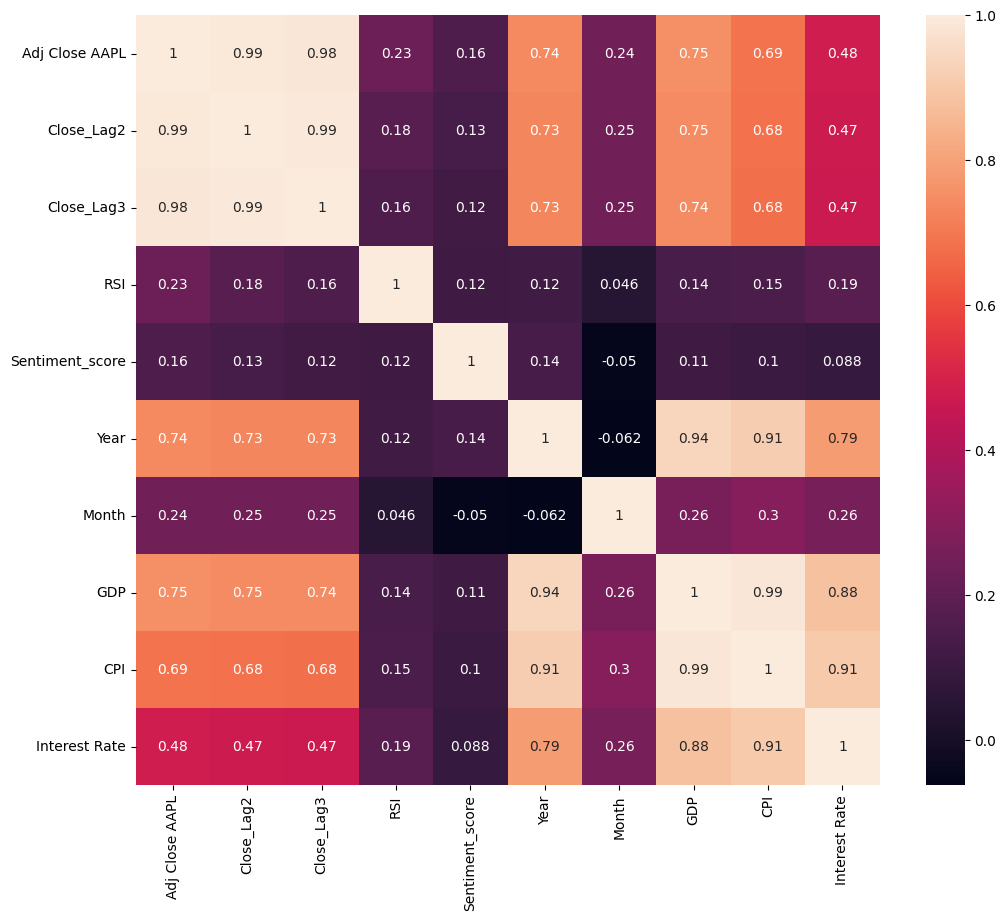

In [478]:
cor=apple_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(cor, annot=True)
plt.show()

## Data Preparation for model
The selection of input features (`X`) and target variable (`y`) for the model.

 Here's a brief explanation:

- **`X`**: The features chosen for prediction include sentiment score (`sent_score`), time-related features (`Year`, `Month`), economic indicators (`GDP`, `CPI`, `Interest Rate`), technical indicators (`RSI`, `Close_Lag2`, `Close_Lag3`). These features provide a mix of sentiment analysis, temporal information, and market dynamics, which may contribute to predicting stock price movements.
- **`y`**: The target variable (`y`) is the adjusted closing price of Apple stock (`Adj Close AAPL`), which the model will aim to predict.

By using these features, the model captures a variety of factors influencing stock prices, ranging from market sentiment to economic trends and technical indicators.


In [480]:
# Select features (X) and target variable (y)
X = apple_df[['Sentiment_score','Year','GDP','CPI','Interest Rate','Month','RSI','Close_Lag2', 'Close_Lag3']]
y = apple_df['Adj Close AAPL']

##### Standardizing and Splitting data into training and testing sets

**Standardization**:

Standardizing the features (X) and target variable (y) is important in machine learning models, especially when using algorithms that are sensitive to the scale of the data (like regression or neural networks). Standardization ensures that all features have a mean of 0 and a standard deviation of 1, which helps improve the convergence speed of gradient-based optimization algorithms and prevents features with larger scales from dominating the model training.

**Avoiding Random Split in Time Series**:

For time series data, it is critical to maintain the temporal order of the data to ensure that the model is trained on past data and validated on future data, which simulates real-world prediction. A random split of data would mix past and future observations, leading to data leakage and unrealistic evaluation of model performance. Therefore, we use the first 80% of the data for training and the remaining 20% for testing, ensuring that the model is evaluated on unseen future data.


In [481]:
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
train_size = int(0.8 * len(X_scaled))
train_X, val_X = X_scaled[:train_size], X_scaled[train_size:]
train_y, val_y = y_scaled[:train_size], y_scaled[train_size:]

## Model Comparison and Evaluation

Multiple machine learning models for predicting stock data (or other target variables), evaluates them using performance metrics, and generates visual comparisons between the actual and predicted values.

1. **Models Definition**:  
   Several regression models are defined in the `models` dictionary, including `Linear Regression`, `Lasso`, `Ridge`, `SVR`, `Random Forest`, `Decision Tree`, and `Gradient Boosting`. These models will be trained and evaluated on the data.

2. **Helper Function (`plot_actual_vs_predicted`)**:  
   A helper function is defined to plot the actual vs. predicted values for each model. The plot is encoded as a base64 string, which is stored for later display.

3. **Model Training and Evaluation**:  
   The loop iterates over each model in the `models` dictionary. For each model:
   - The model is trained on the training data (`train_X`, `train_y`).
   - Predictions are made on the validation data (`val_X`).
   - The predictions and true values are inverse transformed to their original scale.
   - Metrics such as Mean Absolute Error (MAE), Mean Absolute Percentage Error (MAPE), and R2 Score are calculated for evaluation.
   - The actual vs. predicted plot is generated and stored.

4. **Results**:  
   The results (metrics and plots) for each model are stored in a dictionary and converted into a pandas DataFrame for easy viewing. The results include MAE, MAPE, R2 score, and a plot of actual vs. predicted values.

5. **Displaying Results**:  
   The DataFrame is displayed with model performance metrics and a corresponding plot for each model. The plot is rendered as a base64 image for visualization in the notebook interface.


Model: Linear Regression
MAE     3.041376
MAPE    0.014155
R2      0.935417
Name: Linear Regression, dtype: object



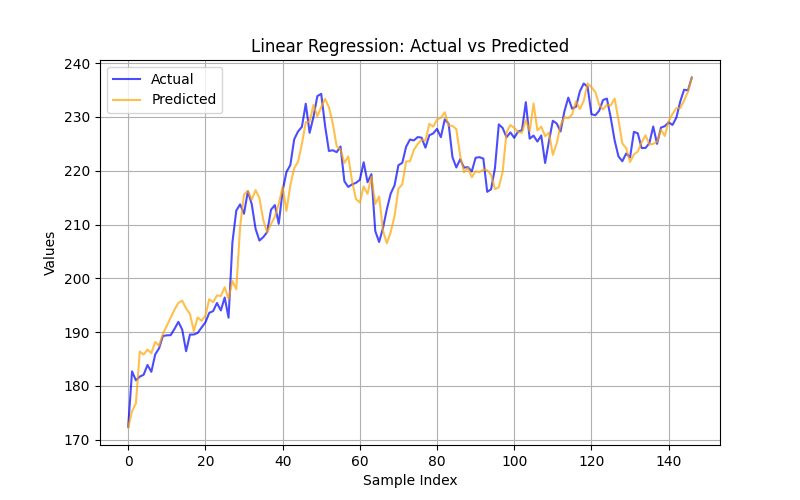


Model: Lasso (L1)
MAE     14.631317
MAPE      0.06633
R2      -0.020151
Name: Lasso (L1), dtype: object



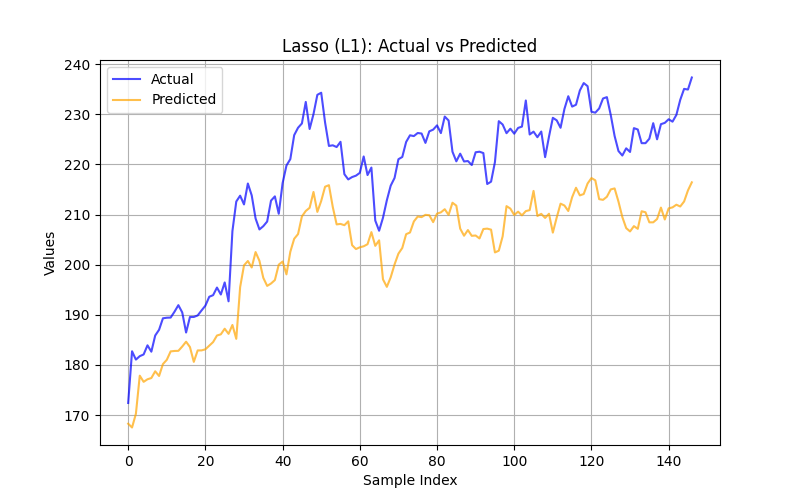


Model: Ridge (L2)
MAE     3.040707
MAPE    0.014146
R2      0.935329
Name: Ridge (L2), dtype: object



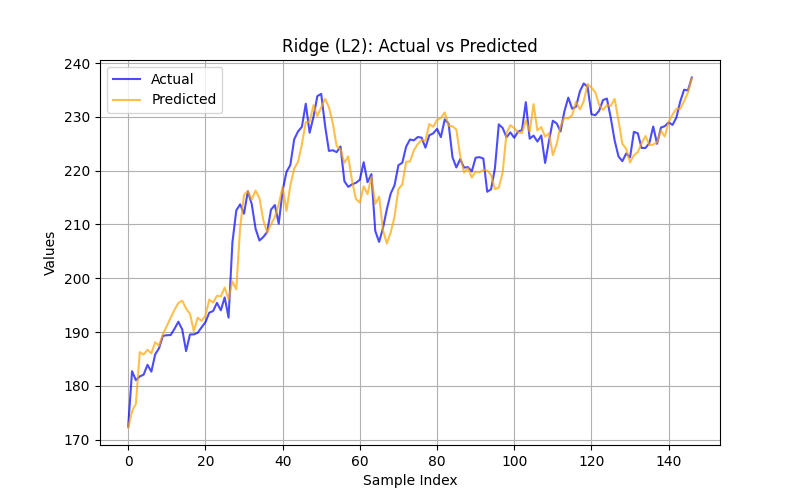


Model: SVR
MAE     33.678551
MAPE     0.150311
R2      -4.937309
Name: SVR, dtype: object



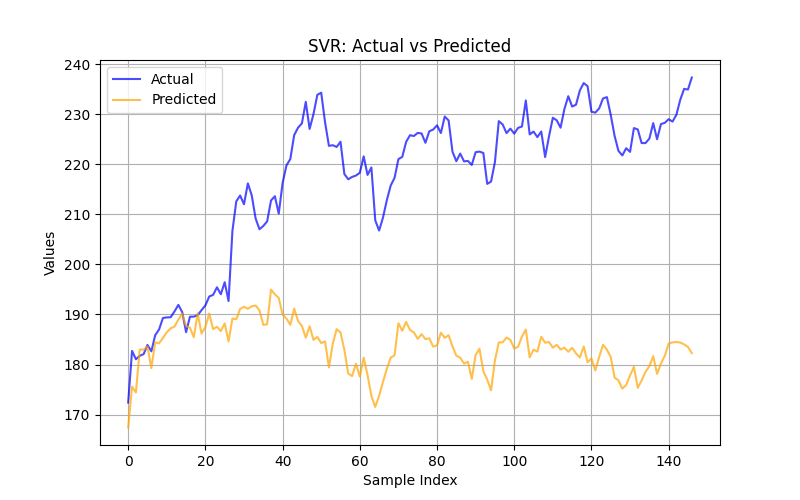


Model: Random Forest
MAE     26.937698
MAPE     0.120152
R2      -2.811313
Name: Random Forest, dtype: object



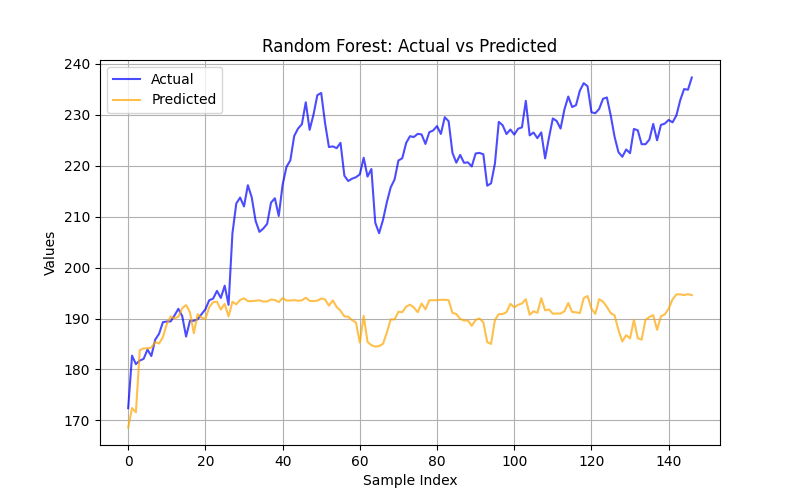


Model: Decision Tree
MAE     26.304467
MAPE     0.117481
R2      -2.598623
Name: Decision Tree, dtype: object



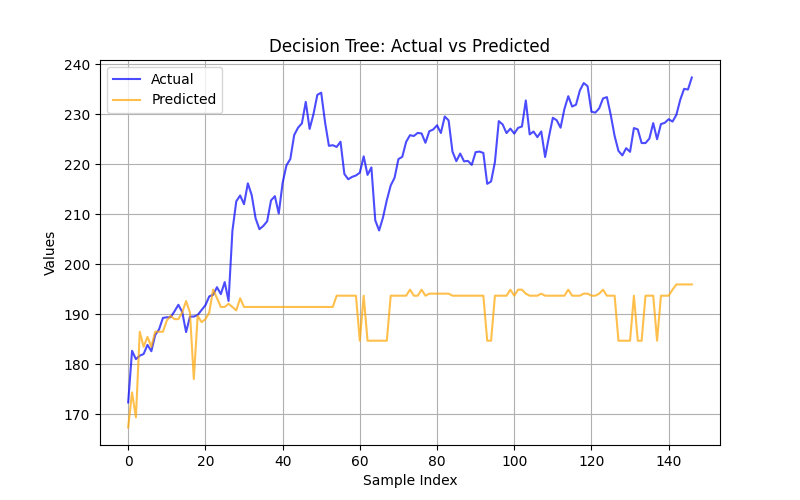


Model: Gradient Boosting
MAE     28.16864
MAPE    0.125687
R2     -3.188363
Name: Gradient Boosting, dtype: object



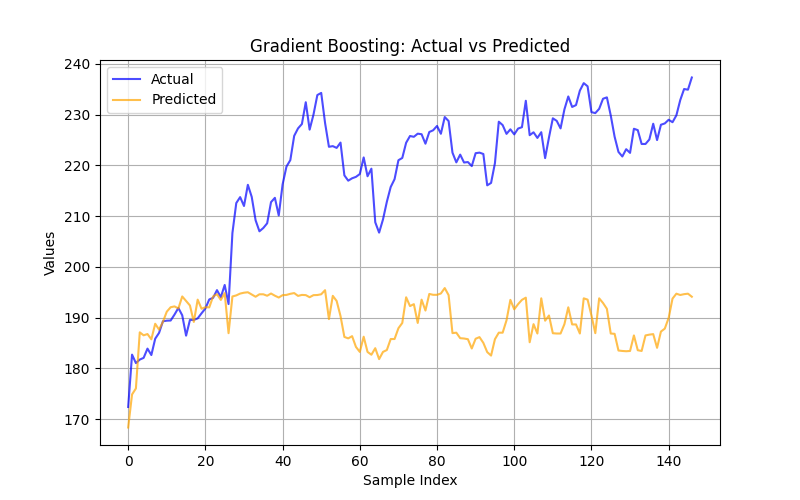

In [482]:
# Dictionary to store model results
results = {}

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Lasso (L1)': Lasso(alpha=0.1),
    'Ridge (L2)': Ridge(alpha=0.1),
    'SVR': SVR(),
    'Random Forest': RandomForestRegressor(
        n_estimators=200,
        random_state=42
    ),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.1,
        random_state=42
    )
}

# Helper function to plot and encode line plot as base64
def plot_actual_vs_predicted(val_y_inv, y_pred_inv, model_name):
    plt.figure(figsize=(8, 5))
    plt.plot(val_y_inv, label='Actual', color='blue', alpha=0.7)
    plt.plot(y_pred_inv, label='Predicted', color='orange', alpha=0.7)
    plt.title(f'{model_name}: Actual vs Predicted')
    plt.xlabel('Sample Index')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)

    # Save the plot to a BytesIO buffer
    buffer = BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)
    plt.close()

    # Encode plot as base64 string
    return base64.b64encode(buffer.getvalue()).decode('utf-8')

# Train and evaluate ML models
plots = {}
for model_name, model in models.items():
    model.fit(train_X, train_y)  # Train the model
    y_pred = model.predict(val_X)  # Predict

    # Inverse transform predictions and validation targets
    y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    val_y_inv = scaler_y.inverse_transform(val_y.reshape(-1, 1)).flatten()

    # Calculate metrics
    mae = mean_absolute_error(val_y_inv, y_pred_inv)
    mape = mean_absolute_percentage_error(val_y_inv, y_pred_inv)
    r2 = r2_score(val_y_inv, y_pred_inv)

    # Generate line plot
    plot_base64 = plot_actual_vs_predicted(val_y_inv, y_pred_inv, model_name)
    plots[model_name] = plot_base64

    # Store results
    results[model_name] = {'MAE': mae, 'MAPE': mape, 'R2': r2}

# Convert results to DataFrame
results_df = pd.DataFrame(results).T

# Add plots as a column in the DataFrame
results_df['Actual vs Predicted Plot'] = pd.Series(plots)

# Display DataFrame
for model_name, row in results_df.iterrows():
    print(f"\nModel: {model_name}")
    print(row.drop('Actual vs Predicted Plot'))  # Print metrics
    # Display the line plot in text-based interface
    display_html = f'<img src="data:image/png;base64,{row["Actual vs Predicted Plot"]}" />'
    display(HTML(display_html))


The `Ridge (L2)` model performs the best among the tested models due to its use of regularization, which helps reduce overfitting by penalizing large coefficients. This results in a more generalized model, as reflected in its low MAE (Mean Absolute Error) and MAPE (Mean Absolute Percentage Error). By preventing overfitting, `Ridge` delivers a more stable and reliable prediction, making it the most effective choice for this task compared to the other models.

## Evaluating the Impact of Reddit Sentiment on Stock Prediction Accuracy
In our project, we are analyzing stock movement by scraping Reddit data, which provides valuable sentiment insights related to stocks. The inclusion of the sentiment score as a feature allows the model to leverage sentiment-driven patterns that could potentially influence stock prices. To evaluate the impact of the sentiment score on accuracy, we will now assess the performance of the best model, Ridge, both with and without the sentiment_score feature. By comparing the results, we can determine if incorporating sentiment data improves the model’s ability to predict stock movements, highlighting the importance of market sentiment in stock forecasting.

###### The below code gives the metrics for model without sentiment as a Feature

In [483]:
#let's remove sent_score from the features and check impact on accuracy
X = apple_df[['Year','GDP','CPI','Interest Rate','Month','RSI','Close_Lag2', 'Close_Lag3']]
y = apple_df['Adj Close AAPL']
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
train_size = int(0.8 * len(X_scaled))
train_X, val_X = X_scaled[:train_size], X_scaled[train_size:]
train_y, val_y = y_scaled[:train_size], y_scaled[train_size:]

# model
Ridge=Ridge(alpha=0.1)
model=Ridge.fit(train_X,train_y)
y_pred=model.predict(val_X)

y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
val_y_inv = scaler_y.inverse_transform(val_y.reshape(-1, 1)).flatten()
MAE= mean_absolute_error(val_y_inv,y_pred_inv)
MAPE=mean_absolute_percentage_error(val_y_inv,y_pred_inv)*100
R2=r2_score(val_y_inv,y_pred_inv)
print(f'Mean Absolute Error Without Sentiment Feature: {MAE}')
print(f'Mean Absolute  Percentage Error Without Sentiment Feature: {MAPE}%')
print(f'R^2 Score without sentiment feature: {R2}')

Mean Absolute Error Without Sentiment Feature: 3.1017184785952656
Mean Absolute  Percentage Error Without Sentiment Feature: 1.440801044937827%
R^2 Score without sentiment feature: 0.9334651535669317


##### The below code gives the metrics for model with sentiment as a Feature

In [485]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
#let's add sent_score  features and check impact on accuracy
X = apple_df[['Sentiment_score','Year','GDP','CPI','Interest Rate','Month','RSI','Close_Lag2', 'Close_Lag3']]
y = apple_df['Adj Close AAPL']
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
train_size = int(0.8 * len(X_scaled))
train_X, val_X = X_scaled[:train_size], X_scaled[train_size:]
train_y, val_y = y_scaled[:train_size], y_scaled[train_size:]

# model_1
Ridge_1=Ridge(alpha=0.1)
model_1=Ridge_1.fit(train_X,train_y)
y_pred=model_1.predict(val_X)

y_pred_inv_1 = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
val_y_inv_1 = scaler_y.inverse_transform(val_y.reshape(-1, 1)).flatten()
MAE_1= mean_absolute_error(val_y_inv_1,y_pred_inv_1)
MAPE_1=mean_absolute_percentage_error(val_y_inv_1,y_pred_inv_1)*100
R2_1=r2_score(val_y_inv_1,y_pred_inv_1)
print(f'Mean Absolute Error With Sentiment Feature: {MAE_1}')
print(f'Mean Absolute  Percentage Error With Sentiment Feature: {MAPE_1}%')
print(f'R^2 Score with sentiment feature: {R2_1}')

Mean Absolute Error With Sentiment Feature: 3.0407065547599514
Mean Absolute  Percentage Error With Sentiment Feature: 1.4145910288966386%
R^2 Score with sentiment feature: 0.9353292127254964


### Visualization of Predicted Price with vs without sentiment analysis

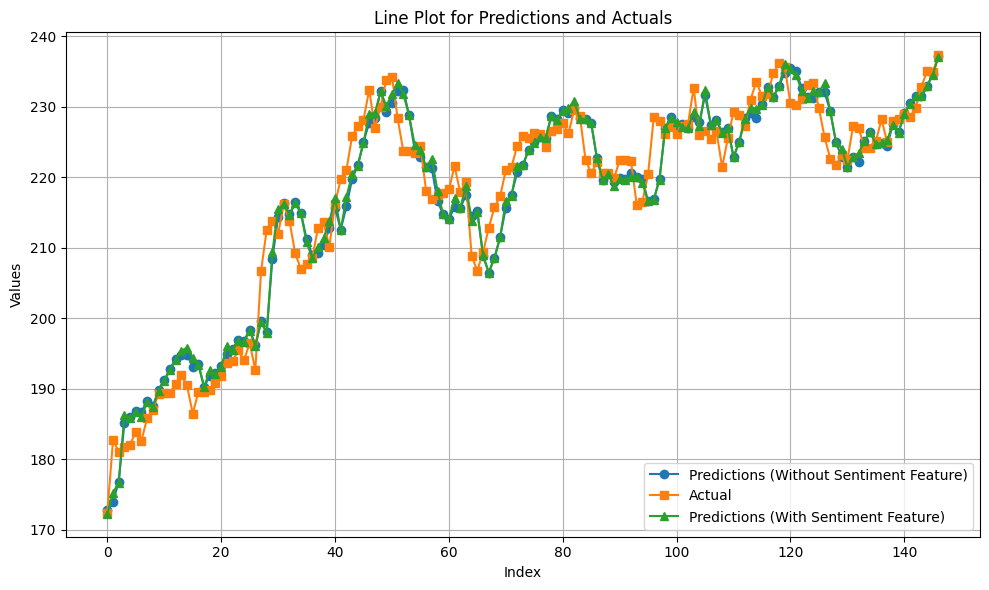

In [486]:
# Create the plot
plt.figure(figsize=(10, 6))
# Plot each variable
# Plot each variable
plt.plot(y_pred_inv, label='Predictions (Without Sentiment Feature)', marker='o')
plt.plot(val_y_inv, label='Actual', marker='s')
plt.plot(y_pred_inv_1, label='Predictions (With Sentiment Feature)', marker='^')

# Add labels, legend, and grid
plt.title('Line Plot for Predictions and Actuals')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

#### Impact of Reddit Sentiment on Stock Prediction Model Performance

The inclusion of Reddit sentiment as a feature resulted in the following differences in model performance:

1. MAE Difference: The Mean Absolute Error (MAE) difference of 0.0599 indicates a small but meaningful improvement in prediction accuracy when sentiment data is included.
2. MAPE Difference: The Mean Absolute Percentage Error (MAPE) difference of 0.0253% reflects a modest enhancement in the model's ability to predict stock movements with greater precision.
3. R2 Score Difference: The increase in R2 score by 0.0019 suggests that the model with sentiment data is slightly better at explaining the variance in stock prices.

These results indicate that incorporating sentiment from Reddit discussions provides a positive but small impact on stock prediction accuracy.

In [487]:
#diff in evaluation metrics
print(f'MAE difference:{MAE-MAE_1}')
print(f'MAPE differnce:{MAPE-MAPE_1}%')
print(f'R2 Score difference:{R2_1-R2}')

MAE difference:0.061011923835314175
MAPE differnce:0.026210016041188444%
R2 Score difference:0.0018640591585646904


## Conclusion and Future Work
**Conclusion**:

Incorporating Reddit sentiment data into the stock prediction model has shown a positive but modest impact on accuracy. The inclusion of the sentiment score improved the model's Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE) while showing a slight increase in the R2 score. However, the differences in performance are relatively small, indicating that sentiment data alone might not be the primary driver of accuracy but can contribute meaningfully to the model's overall predictive power.

**Future Work**:

To further enhance the model's performance, future work could explore the integration of additional features such as news sentiment, macroeconomic indicators, or social media trends across multiple platforms. Additionally, experimenting with more advanced sentiment analysis techniques, incorporating temporal patterns, and using ensemble learning methods may help achieve better accuracy. Expanding the dataset and including more granular data could also improve the model's robustness and predictive capabilities.